In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from catboost import CatBoostClassifier, Pool
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

def analyze_correlations(X, threshold=0.85):
    print(f"\n CORRELATION ANALYSIS")
    print("="*70)
    print(f"   Threshold: {threshold} (>{threshold*100:.0f}% correlation)")
    
    # Correlation matrix hisoblash
    corr_matrix = X.corr().abs()
    
    # Upper triangle
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Yuqori correlation'li pairlar topish
    high_corr_pairs = []
    for column in upper_triangle.columns:
        high_corr = upper_triangle[column][upper_triangle[column] > threshold]
        for idx in high_corr.index:
            high_corr_pairs.append({
                'feature_1': column,
                'feature_2': idx,
                'correlation': high_corr[idx]
            })
    
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    
    print(f"\n Found {len(high_corr_df)} highly correlated pairs (>{threshold}):")
    if len(high_corr_df) > 0:
        print(high_corr_df.head(20).to_string(index=False))
    else:
        print("    No highly correlated features found!")
    
    return high_corr_df, corr_matrix


def remove_correlated_features(X, y, threshold=0.85):
    print(f"\n  REMOVING CORRELATED FEATURES")
    print("="*70)
    print(f"   Threshold: {threshold}")
    
    # Correlation matrix
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Feature importance hisoblash
    print("   Calculating feature importance...")
    temp_model = CatBoostClassifier(
        iterations=100, 
        depth=6,
        class_weights=[1, 20],
        verbose=False, 
        random_seed=42
    )
    temp_model.fit(X, y)
    feature_importance = pd.Series(
        temp_model.feature_importances_, 
        index=X.columns
    )
    
    # O'chiriladigan feature'larni topish
    to_drop = set()
    
    for column in upper_triangle.columns:
        high_corr = upper_triangle[column][upper_triangle[column] > threshold]
        
        for idx in high_corr.index:
            if column not in to_drop and idx not in to_drop:
                # Kam muhimroqni o'chirish
                if feature_importance[column] < feature_importance[idx]:
                    to_drop.add(column)
                else:
                    to_drop.add(idx)
    
    selected_features = [col for col in X.columns if col not in to_drop]
    
    print(f"\n Results:")
    print(f"   Original features:  {X.shape[1]}")
    print(f"   Dropped features:   {len(to_drop)}")
    print(f"   Selected features:  {len(selected_features)}")
    
    if len(to_drop) > 0:
        print(f"\n  Dropped features:")
        for feat in sorted(to_drop)[:15]:
            print(f"      - {feat}")
        if len(to_drop) > 15:
            print(f"      ... and {len(to_drop) - 15} more")
    
    return selected_features, list(to_drop)


def plot_correlation_heatmap(X,y, top_n=30):
    # Agar juda ko'p feature bo'lsa, faqat top N'ni ko'rsatish
    if X.shape[1] > top_n:
        # Feature importance bo'yicha top N
        temp_model = CatBoostClassifier(iterations=50, verbose=False, random_seed=42)
        temp_model.fit(X, y)
        
        feature_importance = pd.Series(
            temp_model.feature_importances_, 
            index=X.columns
        ).sort_values(ascending=False)
        
        top_features = feature_importance.head(top_n).index.tolist()
        X_subset = X[top_features]
        print(f"   Showing top {top_n} most important features")
    else:
        X_subset = X
        print(f"   Showing all {X.shape[1]} features")
    
    # Correlation matrix
    corr_matrix = X_subset.corr()
    
    # Plot
    plt.figure(figsize=(14, 12))
    
    # Heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=False,
        fmt='.2f',
        cmap='RdYlBu_r',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    
    plt.title(f'Feature Correlation Heatmap (Top {len(X_subset.columns)} Features)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    print(f"    Heatmap displayed")

def select_features_with_correlation_check(X, y, max_features=40, corr_threshold=0.85):
    print(f"   Max features: {max_features}")
    print(f"   Correlation threshold: {corr_threshold}")
    
    # Step 1: Initial feature importance
    print(f"\n1 Calculating initial feature importance...")
    temp_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        class_weights=[1, 20],
        random_seed=42,
        verbose=False
    )
    temp_model.fit(X, y)
    
    initial_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': temp_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"    Initial importance calculated")
    
    # Step 2: Correlation analysis
    print(f"\n2 Analyzing correlations...")
    high_corr_pairs, corr_matrix = analyze_correlations(X, threshold=corr_threshold)
    
    # Step 3: Remove correlated features
    print(f"\n3 Removing correlated features...")
    selected_features, dropped_features = remove_correlated_features(
        X, y, threshold=corr_threshold
    )
    
    X_decorrelated = X[selected_features]
    
    # Step 4: Final selection based on importance
    print(f"\n4  Final selection (top {max_features})...")
    
    # Re-calculate importance on decorrelated features
    temp_model2 = CatBoostClassifier(
        iterations=100,
        depth=6,
        class_weights=[1, 20],
        random_seed=42,
        verbose=False
    )
    temp_model2.fit(X_decorrelated, y)
    
    final_importance = pd.DataFrame({
        'feature': X_decorrelated.columns,
        'importance': temp_model2.feature_importances_
    }).sort_values('importance', ascending=False)
    
    final_features = final_importance.head(max_features)['feature'].tolist()
    
    print(f"\n FINAL SELECTION:")
    print(f"   Original:         {X.shape[1]} features")
    print(f"   After decorr:     {len(selected_features)} features")
    print(f"   Final selected:   {len(final_features)} features")
    
    print(f"\n Top 20 Selected Features:")
    print(final_importance.head(20).to_string(index=False))
    
    return final_features, final_importance, high_corr_pairs

def optimize_catboost_with_optuna(X_train, y_train, X_val, y_val, n_trials=30):
    print(f"Running {n_trials} trials...")
    
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 300, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'depth': trial.suggest_int('depth', 4, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'class_weights': [1, trial.suggest_int('class_1_weight', 15, 25)],
            'random_seed': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }
        
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        
        y_proba = model.predict_proba(X_val)[:, 1]
        return float(roc_auc_score(y_val, y_proba))
    
    study = optuna.create_study(direction='maximize', study_name='catboost_optimization')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\n Optimization completed!")
    print(f"   Best ROC-AUC: {study.best_value:.4f}")
    print(f"\n Best Parameters:")
    for key, value in study.best_params.items():
        print(f"   {key:25s}: {value}")
    
    return study.best_params, study.best_value

# ==============================================================================
# CROSS-VALIDATION ENSEMBLE
# ==============================================================================

def train_catboost_with_cv(X_train, y_train, params, n_folds=5):

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    models = []
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = CatBoostClassifier(**params, verbose=False)
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=(X_fold_val, y_fold_val),
            verbose=False
        )
        
        y_proba = model.predict_proba(X_fold_val)[:, 1]
        fold_auc = roc_auc_score(y_fold_val, y_proba)
        
        models.append(model)
        cv_scores.append(fold_auc)
        
        print(f"   Fold {fold}: ROC-AUC = {fold_auc:.4f}")
    
    mean_auc = np.mean(cv_scores)
    std_auc = np.std(cv_scores)
    
    print(f"\n Cross-Validation Results:")
    print(f"   Mean ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    
    return models, mean_auc

def predict_with_cv_ensemble(models, X):

    predictions = []
    for model in models:
        pred = model.predict_proba(X)[:, 1]
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

def identify_feature_types(df, categorical_threshold=10):
    """Feature types aniqlash"""
    numerical_features = []
    categorical_features = []
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            n_unique = df[col].nunique()
            if n_unique > categorical_threshold:
                numerical_features.append(col)
            else:
                categorical_features.append(col)
        else:
            categorical_features.append(col)
    
    return {
        'numerical': numerical_features,
        'categorical': categorical_features
    }

def engineer_features_minimal(df, feature_types=None):
    """Minimal feature engineering"""
    df_enh = df.copy()
    
    if not isinstance(df_enh, pd.DataFrame):
        df_enh = pd.DataFrame(df_enh, columns=[f'feature_{i}' for i in range(df_enh.shape[1])])
    
    if feature_types is None:
        feature_types = identify_feature_types(df_enh, categorical_threshold=10)
    
    numerical_cols = feature_types['numerical']
    categorical_cols = feature_types['categorical']
    
    new_features = []
    
    # 1. Log transform (top 3)
    for col in numerical_cols[:3]:
        if (df_enh[col] > 0).all():
            df_enh[f'{col}_log'] = np.log1p(df_enh[col])
            new_features.append(f'{col}_log')
    
    # 2. Interactions (2x2)
    if len(numerical_cols) >= 2:
        for i in range(min(2, len(numerical_cols))):
            for j in range(i+1, min(3, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                df_enh[f'{col1}_x_{col2}'] = df_enh[col1] * df_enh[col2]
                new_features.append(f'{col1}_x_{col2}')
    
    # 3. Ratios (top 2)
    if len(numerical_cols) >= 2:
        for i in range(min(2, len(numerical_cols))):
            for j in range(i+1, min(3, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                if (df_enh[col2] != 0).all():
                    df_enh[f'{col1}_div_{col2}'] = df_enh[col1] / (df_enh[col2] + 1e-5)
                    new_features.append(f'{col1}_div_{col2}')
    
    # 4. Frequency encoding (categorical)
    for cat_col in categorical_cols:
        freq = df_enh[cat_col].value_counts(normalize=True)
        df_enh[f'{cat_col}_freq'] = df_enh[cat_col].map(freq)
        new_features.append(f'{cat_col}_freq')
    
    # 5. Row statistics
    if len(numerical_cols) >= 3:
        selected = numerical_cols[:min(5, len(numerical_cols))]
        df_enh['row_mean'] = df_enh[selected].mean(axis=1)
        df_enh['row_std'] = df_enh[selected].std(axis=1)
        df_enh['row_max'] = df_enh[selected].max(axis=1)
        df_enh['row_min'] = df_enh[selected].min(axis=1)
        new_features.extend(['row_mean', 'row_std', 'row_max', 'row_min'])
    
    # Fill missing
    df_enh = df_enh.fillna(df_enh.median(numeric_only=True))
    
    return df_enh, new_features, feature_types

# STEP 1: Load Data
print(f"\n STEP 1: Loading Data")
print("="*70)

X = pd.read_csv("../merge/merged_x.csv")
y = pd.read_csv("../merge/merged_y.csv").squeeze()  # Convert to Series

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.28, stratify=y_train, random_state=42
)

print(f" Train: {X_train_split.shape}")
print(f" Val:   {X_val.shape}")
print(f" Test:  {X_test.shape}")

# STEP 2: Feature Engineering
print(f"\n STEP 2: Feature Engineering")
print("="*70)

X_train_enh, _, feature_types = engineer_features_minimal(X_train_split)
X_val_enh = engineer_features_minimal(X_val, feature_types)[0]
X_test_enh = engineer_features_minimal(X_test, feature_types)[0]
X_full_train_enh = engineer_features_minimal(X_train, feature_types)[0]

print(f" Enhanced features: {X_train_enh.shape[1]}")

# STEP 3: Feature Selection WITH CORRELATION CHECK
print(f"\n STEP 3: Feature Selection + Correlation Check")
print("="*70)

n_features = min(40, X_train_enh.shape[1])
final_features, feature_importance, high_corr_pairs = select_features_with_correlation_check(
    X_train_enh, y_train_split,
    max_features=n_features,
    corr_threshold=0.85
)

X_train_selected = X_train_enh[final_features]
X_val_selected = X_val_enh[final_features]
X_test_selected = X_test_enh[final_features]
X_full_train_selected = X_full_train_enh[final_features]

# Visualization (optional - comment out if too slow)
print(f"\n Visualizing correlations...")
try:
    plot_correlation_heatmap(X_train_selected,y_train, top_n=30)
except:
    print("    Visualization skipped")

# STEP 4: Scaling
print(f"\n STEP 4: Scaling")
print("="*70)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=final_features,
    index=X_train_selected.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_selected),
    columns=final_features,
    index=X_val_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=final_features,
    index=X_test_selected.index
)
X_full_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_full_train_selected),
    columns=final_features
)

print(f" Scaling completed")

# STEP 5: Optuna Optimization
print(f"\n  STEP 5: Hyperparameter Tuning")
print("="*70)

n_trials = 30
best_params, best_auc = optimize_catboost_with_optuna(
    X_train_scaled, y_train_split, X_val_scaled, y_val, n_trials=n_trials
)

# STEP 6: Cross-Validation Training
print(f"\n STEP 6: Cross-Validation Training")
print("="*70)

# STEP 6: Cross-Validation Training
print(f"\n STEP 6: Cross-Validation Training")
print("="*70)

cv_params = {
    'iterations': best_params['iterations'],
    'learning_rate': best_params['learning_rate'],
    'depth': best_params['depth'],
    'l2_leaf_reg': best_params['l2_leaf_reg'],
    'min_data_in_leaf': best_params['min_data_in_leaf'],
    'border_count': best_params['border_count'],
    'bagging_temperature': best_params['bagging_temperature'],
    'random_strength': best_params['random_strength'],
    'class_weights': [1, best_params['class_1_weight']], 
    'random_seed': 42,
    'early_stopping_rounds': 50
}

cv_models, cv_mean_auc = train_catboost_with_cv(
    X_full_train_scaled, y_train, cv_params, n_folds=5
)

# STEP 7: Test Set Evaluation
print(f"\n STEP 7: Test Set Evaluation")
print("="*70)

y_proba_test = predict_with_cv_ensemble(cv_models, X_test_scaled)

roc_auc_test = roc_auc_score(y_test, y_proba_test)
pr_auc_test = average_precision_score(y_test, y_proba_test)

# Optimal threshold
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []
for threshold in thresholds:
    y_pred = (y_proba_test >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = (fn * 10000) + (fp * 500)
    costs.append(total_cost)

optimal_threshold = thresholds[np.argmin(costs)]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
total_cost = (fn * 10000) + (fp * 500)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n FINAL TEST METRICS:")
print("="*70)
print(f"   ROC-AUC:     {roc_auc_test:.4f}")
print(f"   PR-AUC:      {pr_auc_test:.4f}")
print(f"   Precision:   {precision:.3f}")
print(f"   Recall:      {recall:.3f}")
print(f"   F1-Score:    {f1:.3f}")
print(f"   Threshold:   {optimal_threshold:.3f}")
print(f"   False Neg:   {fn}")
print(f"   Total Cost:  ${total_cost:,}")
print("="*70)

# STEP 8: Comparison
print(f"\n TAQQOSLASH:")
print("="*70)

comparison = pd.DataFrame({
    'Approach': [
        'Baseline (Original)',
        'Multi-model Ensemble',
        'CatBoost + Correlation Fix'
    ],
    'ROC-AUC': [
        0.7963,
        0.7912,
        roc_auc_test
    ],
    'Cost': [
        '$4,862,500',
        '$5,013,500',
        f'${total_cost:,}'
    ]
})

print(comparison.to_string(index=False))

improvement = (roc_auc_test - 0.7963) * 100
print(f"\n{'OK' if improvement > 0 else 'FAIL'} Baseline'dan o'zgarish: {improvement:+.2f}%")

print(f"\n OPTIMIZATION COMPLETED!")
print("="*70)

print(f"\n TOP 15 MOST IMPORTANT FEATURES:")
print("="*70)
print(feature_importance.head(15).to_string(index=False))



 STEP 1: Loading Data
 Train: (48599, 52)
 Val:   (18900, 52)
 Test:  (22500, 52)

 STEP 2: Feature Engineering
 Enhanced features: 81

 STEP 3: Feature Selection + Correlation Check
   Max features: 40
   Correlation threshold: 0.85

1 Calculating initial feature importance...
    Initial importance calculated

2 Analyzing correlations...

 CORRELATION ANALYSIS
   Threshold: 0.85 (>85% correlation)

 Found 82 highly correlated pairs (>0.85):
                        feature_1                  feature_2  correlation
              annual_debt_payment total_monthly_debt_payment     1.000000
        oldest_account_age_months     oldest_credit_line_age     1.000000
          num_public_records_freq         num_public_records     1.000000
             recent_inquiry_count          num_inquiries_6mo     1.000000
        recent_inquiry_count_freq     num_inquiries_6mo_freq     1.000000
                          row_min        loan_to_value_ratio     1.000000
           paperless_billing_freq 

Best trial: 24. Best value: 0.80054: 100%|██████████| 30/30 [05:33<00:00, 11.11s/it] 



 Optimization completed!
   Best ROC-AUC: 0.8005

 Best Parameters:
   iterations               : 573
   learning_rate            : 0.06179761986415501
   depth                    : 4
   l2_leaf_reg              : 8.305242639154285
   min_data_in_leaf         : 29
   border_count             : 69
   bagging_temperature      : 0.5700790941422166
   random_strength          : 3.3885117135758445
   class_1_weight           : 17

 STEP 6: Cross-Validation Training

 STEP 6: Cross-Validation Training
   Fold 1: ROC-AUC = 0.7706
   Fold 2: ROC-AUC = 0.8042
   Fold 3: ROC-AUC = 0.7873
   Fold 4: ROC-AUC = 0.7864
   Fold 5: ROC-AUC = 0.8077

 Cross-Validation Results:
   Mean ROC-AUC: 0.7912 ± 0.0135

 STEP 7: Test Set Evaluation

 FINAL TEST METRICS:
   ROC-AUC:     0.8023
   PR-AUC:      0.2333
   Precision:   0.126
   Recall:      0.735
   F1-Score:    0.215
   Threshold:   0.450
   False Neg:   304
   Total Cost:  $5,980,500

 TAQQOSLASH:
                  Approach  ROC-AUC       Cost
   

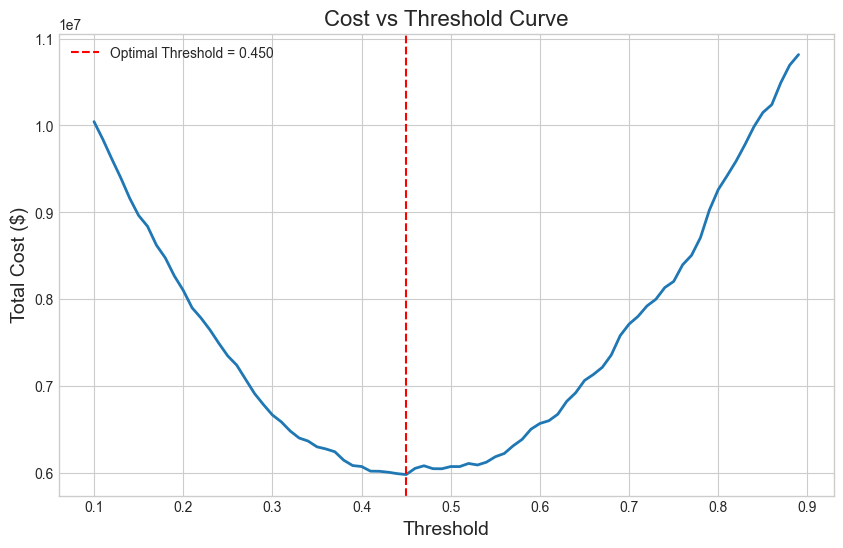

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, costs, linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f"Optimal Threshold = {optimal_threshold:.3f}")

plt.title("Cost vs Threshold Curve", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Total Cost ($)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

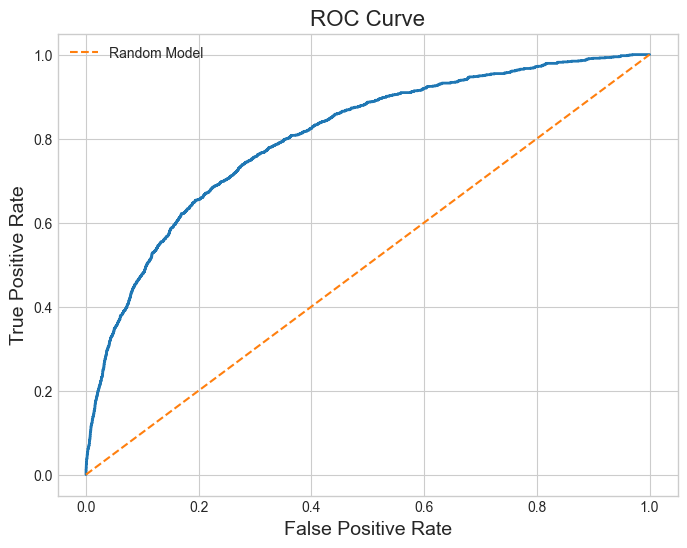

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', label='Random Model')

plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

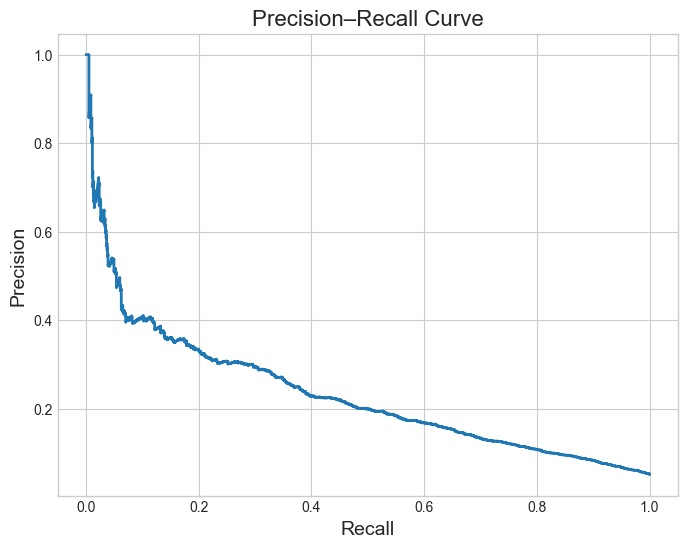

In [19]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba_test)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, linewidth=2)

plt.title("Precision–Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.grid(True)
plt.show()


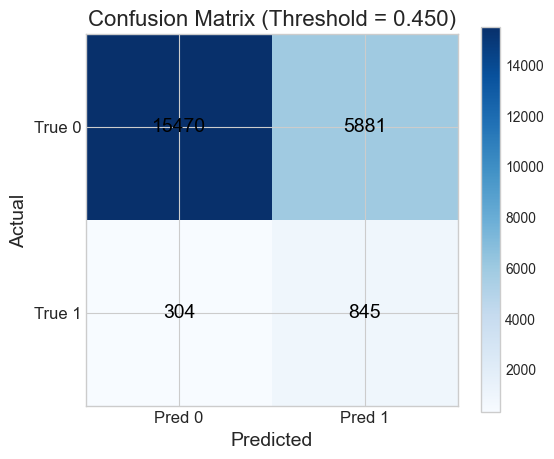

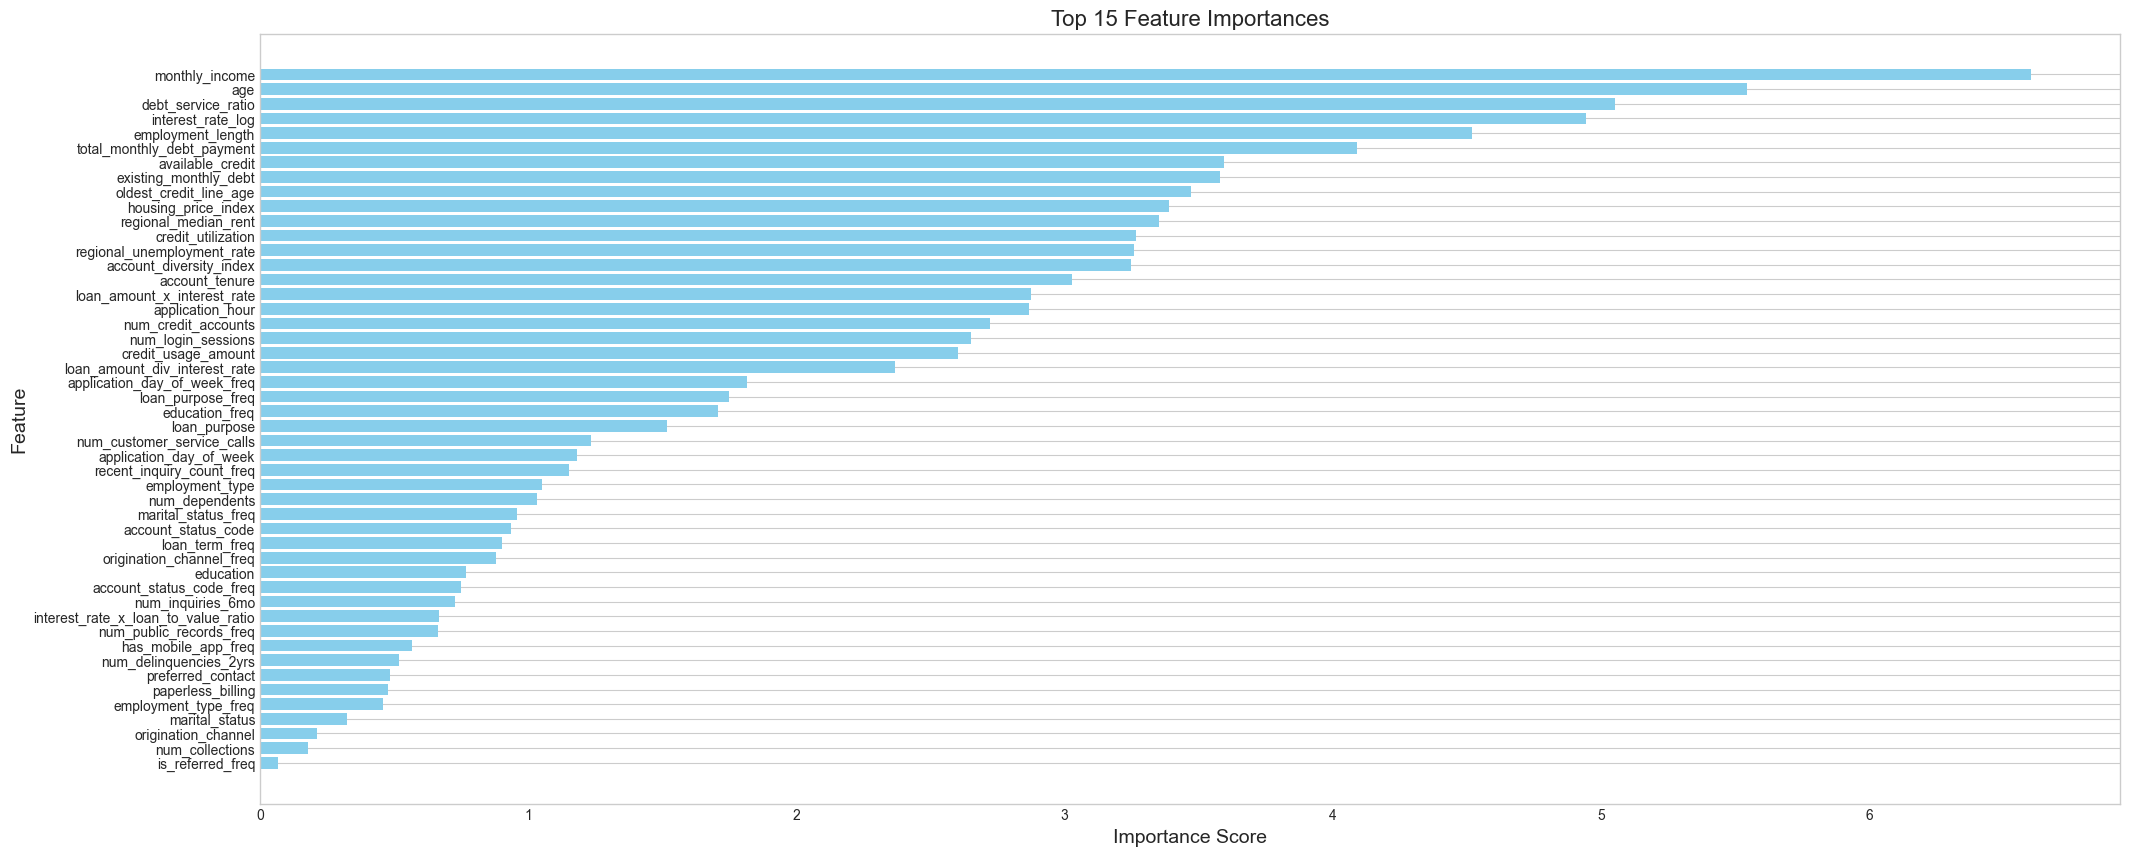

In [20]:
# ==============================================================================
# VISUALIZATIONS FOR PRESENTATION
# ==============================================================================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

plt.style.use('seaborn-v0_8-whitegrid')  # Clean presentation style

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Threshold = {:.3f})".format(optimal_threshold), fontsize=16)
plt.colorbar()

plt.xticks([0,1], ["Pred 0", "Pred 1"], fontsize=12)
plt.yticks([0,1], ["True 0", "True 1"], fontsize=12)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', fontsize=14, color="black")

plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.show()

top15 = feature_importance.head(60)

plt.figure(figsize=(24,10))
plt.barh(top15['feature'], top15['importance'], color='skyblue')
plt.gca().invert_yaxis()

plt.title("Top 15 Feature Importances", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x')
plt.show()


In [21]:
real_data = pd.read_csv("../test/merged_x.csv")


In [22]:
"""
REAL DATA PREDICTION - SIMPLE VERSION
======================================
Allaqachon o'rgatilgan model bilan real data'ni predict qilish
"""

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("REAL DATA PREDICTION")
print("="*80)

# cv_models - sizning trained modellaringiz
# scaler - sizning scaler'ingiz
# selected_features / final_features - feature list
# optimal_threshold - threshold
# feature_types - feature types dict

# Agar bu o'zgaruvchilar hali mavjud bo'lmasa, ularni pickle'dan yuklang:
# import pickle
# with open('best_catboost_with_correlation.pkl', 'rb') as f:
#     data = pickle.load(f)
#     cv_models = data['models']
#     scaler = data['scaler']
#     final_features = data['selected_features']
#     optimal_threshold = data['optimal_threshold']
#     feature_types = data['feature_types']

def identify_feature_types(df, categorical_threshold=10):
    """Feature types aniqlash"""
    numerical_features = []
    categorical_features = []
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            n_unique = df[col].nunique()
            if n_unique > categorical_threshold:
                numerical_features.append(col)
            else:
                categorical_features.append(col)
        else:
            categorical_features.append(col)
    
    return {
        'numerical': numerical_features,
        'categorical': categorical_features
    }

def engineer_features_minimal(df, feature_types=None):
    """Feature engineering - TRAINING BILAN BIR XIL"""
    df_enh = df.copy()
    
    if not isinstance(df_enh, pd.DataFrame):
        df_enh = pd.DataFrame(df_enh, columns=[f'feature_{i}' for i in range(df_enh.shape[1])])
    
    if feature_types is None:
        feature_types = identify_feature_types(df_enh, categorical_threshold=10)
    
    numerical_cols = feature_types['numerical']
    categorical_cols = feature_types['categorical']
    
    new_features = []
    
    # 1. Log transform (top 3)
    for col in numerical_cols[:3]:
        if col in df_enh.columns and (df_enh[col] > 0).all():
            df_enh[f'{col}_log'] = np.log1p(df_enh[col])
            new_features.append(f'{col}_log')
    
    # 2. Interactions (2x2)
    if len(numerical_cols) >= 2:
        for i in range(min(2, len(numerical_cols))):
            for j in range(i+1, min(3, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                if col1 in df_enh.columns and col2 in df_enh.columns:
                    df_enh[f'{col1}_x_{col2}'] = df_enh[col1] * df_enh[col2]
                    new_features.append(f'{col1}_x_{col2}')
    
    # 3. Ratios (top 2)
    if len(numerical_cols) >= 2:
        for i in range(min(2, len(numerical_cols))):
            for j in range(i+1, min(3, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                if col1 in df_enh.columns and col2 in df_enh.columns:
                    if (df_enh[col2] != 0).all():
                        df_enh[f'{col1}_div_{col2}'] = df_enh[col1] / (df_enh[col2] + 1e-5)
                        new_features.append(f'{col1}_div_{col2}')
    
    # 4. Frequency encoding (categorical)
    for cat_col in categorical_cols:
        if cat_col in df_enh.columns:
            freq = df_enh[cat_col].value_counts(normalize=True)
            df_enh[f'{cat_col}_freq'] = df_enh[cat_col].map(freq).fillna(0)
            new_features.append(f'{cat_col}_freq')
    
    # 5. Row statistics
    if len(numerical_cols) >= 3:
        selected = [col for col in numerical_cols[:min(5, len(numerical_cols))] if col in df_enh.columns]
        if len(selected) >= 3:
            df_enh['row_mean'] = df_enh[selected].mean(axis=1)
            df_enh['row_std'] = df_enh[selected].std(axis=1)
            df_enh['row_max'] = df_enh[selected].max(axis=1)
            df_enh['row_min'] = df_enh[selected].min(axis=1)
            new_features.extend(['row_mean', 'row_std', 'row_max', 'row_min'])
    
    # Fill missing
    df_enh = df_enh.fillna(df_enh.median(numeric_only=True))
    
    return df_enh, new_features, feature_types

def predict_with_cv_ensemble(models, X):
    """CV ensemble prediction"""
    predictions = []
    for model in models:
        pred = model.predict_proba(X)[:, 1]
        predictions.append(pred)
    return np.mean(predictions, axis=0)


# MAIN PREDICTION FUNCTION

def predict_real_data(
    real_data_path,
    cv_models,
    scaler,
    final_features,
    optimal_threshold,
    feature_types,
    extra_column_name=None,
    output_path="real_predictions.csv"
):
    """
    Real data'ni predict qilish
    
    Parameters:
    -----------
    real_data_path : str
        Real data file path (CSV)
    cv_models : list
        Trained CV models
    scaler : StandardScaler
        Fitted scaler
    final_features : list
        Final selected feature names
    optimal_threshold : float
        Optimal threshold for classification
    feature_types : dict
        Feature types {'numerical': [...], 'categorical': [...]}
    extra_column_name : str, optional
        Ortiqcha column nomi (masalan: 'customer_id', 'id')
    output_path : str
        Output file path
    
    Returns:
    --------
    DataFrame with predictions
    """
    
    print("\n" + "="*70)
    print("STARTING PREDICTION PIPELINE")
    print("="*70)
    
    # STEP 1: Load real data
    print("\n Loading real data...")
    real_df = pd.read_csv(real_data_path)
    print(f" Loaded: {real_df.shape}")
    print(f"   Columns: {list(real_df.columns)}")
    
    # STEP 2: Remove extra column if specified
    if extra_column_name and extra_column_name in real_df.columns:
        print(f"\n Removing extra column: '{extra_column_name}'")
        extra_data = real_df[extra_column_name].copy()
        real_df_clean = real_df.drop(columns=[extra_column_name])
    else:
        print(f"\n No extra column to remove")
        extra_data = None
        real_df_clean = real_df.copy()
    
    print(f" Clean data: {real_df_clean.shape}")
    
    # STEP 3: Feature engineering
    real_df_eng, _, _ = engineer_features_minimal(real_df_clean, feature_types)
    print(f" Engineered: {real_df_eng.shape[1]} features")
    
    # STEP 4: Check missing features
    print(f"\n Selecting required features...")
    missing = [f for f in final_features if f not in real_df_eng.columns]
    
    if missing:
        print(f"  {len(missing)} missing features (filling with 0):")
        for feat in missing[:5]:
            print(f"     - {feat}")
        if len(missing) > 5:
            print(f"     ... and {len(missing)-5} more")
        
        for feat in missing:
            real_df_eng[feat] = 0
    
    # Select features
    real_X = real_df_eng[final_features]
    print(f" Selected: {real_X.shape[1]} features")
    
    # STEP 5: Scaling
    print(f"\n Scaling features...")
    real_X_scaled = pd.DataFrame(
        scaler.transform(real_X),
        columns=final_features,
        index=real_X.index
    )
    print(f" Scaled!")
    
    # STEP 6: Prediction
    print(f"\n Making predictions...")
    real_proba = predict_with_cv_ensemble(cv_models, real_X_scaled)
    real_pred = (real_proba >= optimal_threshold).astype(int)
    
    print(f" Predictions done!")
    print(f"   Total: {len(real_pred)}")
    print(f"   Class 0 (Approve): {(real_pred==0).sum()} ({(real_pred==0).sum()/len(real_pred)*100:.1f}%)")
    print(f"   Class 1 (Reject):  {(real_pred==1).sum()} ({(real_pred==1).sum()/len(real_pred)*100:.1f}%)")
    
    # STEP 7: Create results
    print(f"\n Creating results...")
    result = real_df.copy()
    result["probability_score"] = real_proba
    result["prediction"] = real_pred
    result["risk_level"] = pd.cut(
        real_proba,
        bins=[0, 0.3, 0.5, 0.7, 1.0],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    
    # Save
    result.to_csv(output_path, index=False)
    print(f" Saved to: {output_path}")
    
    # STEP 8: Summary
    print(f"\n" + "="*70)
    print("PREDICTION SUMMARY")
    print("="*70)
    print(f"\n Threshold: {optimal_threshold:.3f}")
    print(f"\n Predictions:")
    print(result['prediction'].value_counts().to_string())
    print(f"\n Risk Levels:")
    print(result['risk_level'].value_counts().to_string())
    print(f"\n Score Statistics:")
    print(f"   Min:    {real_proba.min():.4f}")
    print(f"   Max:    {real_proba.max():.4f}")
    print(f"   Mean:   {real_proba.mean():.4f}")
    print(f"   Median: {np.median(real_proba):.4f}")
    
    print(f"\n COMPLETED!")
    print("="*70)
    
    return result

# ==============================================================================
# QANDAY ISHLATISH
# ==============================================================================

if __name__ == "__main__":
    
    print("""
    ╔════════════════════════════════════════════════════════════╗
    ║         REAL DATA PREDICTION - USAGE EXAMPLE               ║
    ╚════════════════════════════════════════════════════════════╝
    
    VARIANT 1: Agar model hali xotirada bo'lsa (training'dan keyim)
    ================================================================
    
    result = predict_real_data(
        real_data_path="real_data.csv",
        cv_models=cv_models,              # Training'dan
        scaler=scaler,                     # Training'dan
        final_features=final_features,     # Training'dan
        optimal_threshold=optimal_threshold, # Training'dan
        feature_types=feature_types,       # Training'dan
        extra_column_name="customer_id",   # Agar ortiqcha column bo'lsa
        output_path="predictions.csv"
    )
    
    
    VARIANT 2: Agar model pickle'da saqlangan bo'lsa
    =================================================
    
    import pickle
    
    # Load model
    with open('best_catboost_with_correlation.pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Predict
    result = predict_real_data(
        real_data_path="real_data.csv",
        cv_models=data['models'],
        scaler=data['scaler'],
        final_features=data['selected_features'],
        optimal_threshold=data['optimal_threshold'],
        feature_types=data['feature_types'],
        extra_column_name=None,  # Agar yo'q bo'lsa None
        output_path="predictions.csv"
    )
    
    # Results
    print(result.head(10))
    """)
    
    
    # # Agar model xotirada bo'lsa:
    result = predict_real_data(
         real_data_path="../test/merged_x.csv",
         cv_models=cv_models,
         scaler=scaler,
         final_features=final_features,
         optimal_threshold=optimal_threshold,
         feature_types=feature_types,
         extra_column_name="id",  # yoki None
         output_path="predictions.csv"
    )
    
    


REAL DATA PREDICTION

    ╔════════════════════════════════════════════════════════════╗
    ║         REAL DATA PREDICTION - USAGE EXAMPLE               ║
    ╚════════════════════════════════════════════════════════════╝

    VARIANT 1: Agar model hali xotirada bo'lsa (training'dan keyim)

    result = predict_real_data(
        real_data_path="real_data.csv",
        cv_models=cv_models,              # Training'dan
        scaler=scaler,                     # Training'dan
        final_features=final_features,     # Training'dan
        optimal_threshold=optimal_threshold, # Training'dan
        feature_types=feature_types,       # Training'dan
        extra_column_name="customer_id",   # Agar ortiqcha column bo'lsa
        output_path="predictions.csv"
    )


    VARIANT 2: Agar model pickle'da saqlangan bo'lsa

    import pickle

    # Load model
    with open('best_catboost_with_correlation.pkl', 'rb') as f:
        data = pickle.load(f)

    # Predict
    result = predict_real_

 Engineered: 65 features

 Selecting required features...
  10 missing features (filling with 0):
     - total_monthly_debt_payment
     - application_hour
     - num_credit_accounts
     - num_login_sessions
     - credit_usage_amount
     ... and 5 more
 Selected: 40 features

 Scaling features...
 Scaled!

 Making predictions...
 Predictions done!
   Total: 10001
   Class 0 (Approve): 6848 (68.5%)
   Class 1 (Reject):  3153 (31.5%)

 Creating results...
 Saved to: predictions.csv

PREDICTION SUMMARY

 Threshold: 0.450

 Predictions:
prediction
0    6848
1    3153

 Risk Levels:
risk_level
Low          4432
Medium       3004
High         1731
Very High     834

 Score Statistics:
   Min:    0.0407
   Max:    0.9430
   Mean:   0.3658
   Median: 0.3310

 COMPLETED!


In [ ]:
# A.csv faylni o‘qiymiz
df = pd.read_csv("predictions.csv")

# Faqat kerakli ustunlar
columns_to_keep = ["customer_id", "probability_score", "prediction"] 

# Yangi DataFrame
new_df = df[columns_to_keep]

# Yangi CSV ga saqlash
new_df.to_csv("../results.csv", index=False)

print(" result.csv fayl yaratildi!")
print(new_df.head())


 result.csv fayl yaratildi!
   customer_id  probability_score  prediction
0       100000           0.154708           0
1       100001           0.232572           0
2       100002           0.582734           1
3       100003           0.437034           0
4       100004           0.579072           1
